<a href="https://colab.research.google.com/github/Andrea-1704/Pytorch_Geometric_tutorial/blob/main/train_model_baseline_f1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Obiettivo
Verifichiamo che succede se non mettiamo la gnn per questo task: i risultati peggiorano?

# Libraries to install

In [48]:
# !pip install torch==2.6.0+cu118 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# !pip install pyg-lib -f https://data.pyg.org/whl/torch-2.6.0+cu118.html
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-2.6.0+cu118.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-2.6.0+cu118.html
# !pip install torch-cluster -f https://data.pyg.org/whl/torch-2.6.0+cu118.html
# !pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.6.0+cu118.html
# !pip install torch-geometric==2.6.0 -f https://data.pyg.org/whl/torch-2.6.0+cu118.html

# !pip install pytorch_frame[full]==1.2.2
# !pip install relbench[full]==1.0.0

# Import

In [49]:
import os
import torch
import relbench
import numpy as np
from torch.nn import BCEWithLogitsLoss, L1Loss
from relbench.datasets import get_dataset
from relbench.tasks import get_task
import math
from tqdm import tqdm
import torch_geometric
import torch_frame
from torch_geometric.seed import seed_everything
from relbench.modeling.utils import get_stype_proposal
from collections import defaultdict
import requests
from io import StringIO
from torch_frame.config.text_embedder import TextEmbedderConfig
from relbench.modeling.graph import make_pkey_fkey_graph
from torch.nn import BCEWithLogitsLoss
import copy
from typing import Any, Dict, List
from torch import Tensor
from torch.nn import Embedding, ModuleDict
from torch_frame.data.stats import StatType
from torch_geometric.data import HeteroData
from torch_geometric.nn import MLP
from torch_geometric.typing import NodeType
from relbench.modeling.nn import HeteroEncoder, HeteroGraphSAGE, HeteroTemporalEncoder
from relbench.modeling.graph import get_node_train_table_input, make_pkey_fkey_graph
from torch_geometric.loader import NeighborLoader
import pyg_lib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import roc_auc_score

# Dataset and task creation

In [50]:
dataset = get_dataset("rel-f1", download=True)
task = get_task("rel-f1", "driver-top3", download=True)

train_table = task.get_table("train") #date  driverId  qualifying
val_table = task.get_table("val") #date  driverId  qualifying
test_table = task.get_table("test") # date  driverId

out_channels = 1
loss_fn = BCEWithLogitsLoss()
tune_metric = "roc_auc"
higher_is_better = True

seed_everything(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
root_dir = "./data"

db = dataset.get_db() #get all tables
col_to_stype_dict = get_stype_proposal(db)
#this is used to get the stype of the columns

cuda


#Utility functions

In [51]:
def evaluate_performance(pred: np.ndarray, target_table, metrics) -> dict:
    """Custom evaluation function to replace task.evaluate."""
    target = target_table.df[task.target_col].to_numpy()

    if len(pred) != len(target):
        raise ValueError(
            f"The length of pred and target must be the same (got "
            f"{len(pred)} and {len(target)}, respectively)."
        )

    results = {}
    for metric_fn in metrics:
        if metric_fn.__name__ == "rmse":
            results["rmse"] = np.sqrt(np.mean((target - pred)**2))
        else:
            results[metric_fn.__name__] = metric_fn(target, pred)

    return results

In [52]:
def rmse(true, pred):
    """Calculate the Root Mean Squared Error (RMSE)."""
    return np.sqrt(np.mean((true - pred)**2))

In [53]:
@torch.no_grad()
def evaluate_on_full_train(model, loader) -> float:
    model.eval()
    pred_list, target_list = [], []

    for batch in loader:
        batch = batch.to(device)
        pred = model(batch, task.entity_table)
        pred = pred.view(-1) if pred.size(1) == 1 else pred
        pred = torch.sigmoid(pred)
        pred_list.append(pred.cpu())
        target_list.append(batch[task.entity_table].y.cpu())

    pred_all = torch.cat(pred_list, dim=0).numpy()
    target_all = torch.cat(target_list, dim=0).numpy()

    #mae = np.mean(np.abs(pred_all - target_all))
    results = roc_auc_score(target_all, pred_all)
    return results


In [54]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0, verbose=False, path='checkpoint.pt'):
        """
        Args:
            patience (int): Epoche senza miglioramenti da tollerare.
            delta (float): Cambiamento minimo per considerare un miglioramento.
            verbose (bool): Se stampare i messaggi.
            path (str): Dove salvare il modello migliore.
            higher_is_better (bool): True se la metrica va massimizzata (es: AUC), False se minimizzata (es: MAE).
        """
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_metric = None
        self.delta = delta
        self.verbose = verbose
        self.path = path
        self.higher_is_better = higher_is_better

    def __call__(self, metric_value, model):
        score = metric_value if self.higher_is_better else -metric_value

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(metric_value, model)

        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} / {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_score = score
            self.save_checkpoint(metric_value, model)
            self.counter = 0

    def save_checkpoint(self, metric_value, model):
        if self.verbose:
            print(f"Validation metric migliorata. Salvo modello...")
        torch.save(model.state_dict(), self.path)
        self.best_metric = metric_value


# Embedder

In [55]:
class LightweightGloveEmbedder:
    def __init__(self, device=None):
        self.device = device
        self.embeddings = defaultdict(lambda: np.zeros(300))
        self._load_embeddings()

    def _load_embeddings(self):
      try:
          path = "glove.6B.300d.txt"
          with open(path, encoding="utf-8") as f:
              for line in f:
                  parts = line.strip().split()
                  word = parts[0]
                  vector = np.array(parts[1:], dtype=np.float32)
                  self.embeddings[word] = vector
          print(f"Loaded {len(self.embeddings)} GloVe embeddings.")
      except Exception as e:
          print(f"Failed to load GloVe: {e}")

    def __call__(self, sentences):
        results = []
        for text in sentences:
            words = text.lower().split()
            vectors = [self.embeddings[w] for w in words if w in self.embeddings]
            if vectors:
                avg_vector = np.mean(vectors, axis=0)
            else:
                print("non trovato")
                print(f"Numero parole in embedding: {len(self.embeddings)}")

                avg_vector = np.zeros(300)
            results.append(avg_vector)

        tensor = torch.tensor(np.array(results), dtype=torch.float32)
        return tensor.to(self.device) if self.device else tensor

In [56]:
text_embedder_cfg = TextEmbedderConfig(
    text_embedder=LightweightGloveEmbedder(device=device), batch_size=256
)

data, col_stats_dict = make_pkey_fkey_graph(
    db,
    col_to_stype_dict=col_to_stype_dict,
    text_embedder_cfg=text_embedder_cfg,
    cache_dir=os.path.join(
        root_dir, f"rel-f1_materialized_cache"
    ),
)

Failed to load GloVe: [Errno 2] No such file or directory: 'glove.6B.300d.txt'


/usr/local/lib/python3.11/dist-packages/torch_frame/utils/io.py:113: UserWarning: Weights only load failed. Please file an issue to make `torch.load(weights_only=True)` compatible in your case. Please use `torch.serialization.add_safe_globals([scalar])` to allowlist this global.
  warnings.warn(f"{warn_msg} Please use "
/usr/local/lib/python3.11/dist-packages/torch_frame/utils/io.py:113: UserWarning: Weights only load failed. Please file an issue to make `torch.load(weights_only=True)` compatible in your case. Please use `torch.serialization.add_safe_globals([scalar])` to allowlist this global.
  warnings.warn(f"{warn_msg} Please use "
/usr/local/lib/python3.11/dist-packages/torch_frame/utils/io.py:113: UserWarning: Weights only load failed. Please file an issue to make `torch.load(weights_only=True)` compatible in your case. Please use `torch.serialization.add_safe_globals([scalar])` to allowlist this global.
  warnings.warn(f"{warn_msg} Please use "
/usr/local/lib/python3.11/dist-pac

# Graph Loader

In [57]:
loader_dict = {}

for split, table in [
    ("train", train_table),
    ("val", val_table),
    ("test", test_table),
]:
    table_input = get_node_train_table_input(
        table=table,
        task=task,
    )

    entity_table = table_input.nodes[0]

    loader_dict[split] = NeighborLoader(
        data,
        num_neighbors=[
            128 for i in range(2) #################################
        ],
        time_attr="time",
        input_nodes=table_input.nodes,
        input_time=table_input.time,
        transform=table_input.transform,
        batch_size=512,
        temporal_strategy="uniform",
        shuffle=split == "train",
        num_workers=0,
        persistent_workers=False,
    )

In [58]:
# qui i parametri di train_table, val_table, test_table, task e data sono
#parametri globali

def loader_dict_fn(batch_size, num_neighbours):
    loader_dict = {}

    for split, table in [
        ("train", train_table),
        ("val", val_table),
        ("test", test_table),
    ]:
        table_input = get_node_train_table_input(
            table=table,
            task=task,
        )

        loader_dict[split] = NeighborLoader(
            data,
            num_neighbors=[num_neighbours for _ in range(2)],
            time_attr="time",
            input_nodes=table_input.nodes,
            input_time=table_input.time,
            transform=table_input.transform,
            batch_size=batch_size,
            temporal_strategy="uniform",
            shuffle=split == "train",
            num_workers=0,
            persistent_workers=False,
        )

    return loader_dict


# Model

In [59]:
class Model(torch.nn.Module):

    def __init__(
        self,
        data: HeteroData,
        col_stats_dict: Dict[str, Dict[str, Dict[StatType, Any]]],
        num_layers: int,
        channels: int,
        out_channels: int,
        aggr: str,
        norm: str,
        shallow_list: List[NodeType] = [],
        id_awareness: bool = False,
    ):
        super().__init__()

        self.encoder = HeteroEncoder(
            channels=channels,
            node_to_col_names_dict={
                node_type: data[node_type].tf.col_names_dict
                for node_type in data.node_types
            },
            node_to_col_stats=col_stats_dict,
        )

        self.temporal_encoder = HeteroTemporalEncoder(
            node_types=[
                node_type for node_type in data.node_types if "time" in data[node_type]
            ],
            channels=channels,
        )

        self.pre_gnn_mlp = torch.nn.ModuleDict({
            node_type: MLP(
                in_channels=channels,
                hidden_channels=channels,
                out_channels=channels,
                num_layers=3,
                norm=norm,
            )
            for node_type in data.node_types
        })



        self.gnn = HeteroGraphSAGE(
            node_types=data.node_types,
            edge_types=data.edge_types,
            channels=channels,
            aggr=aggr,
            num_layers=num_layers,
        )
        self.head = MLP(
            channels,
            out_channels=out_channels,
            #hidden_channels=channels,
            norm=norm,
            num_layers=1, ###################################################
        )
        self.embedding_dict = ModuleDict(
            {
                node: Embedding(data.num_nodes_dict[node], channels)
                for node in shallow_list
            }
        )

        self.id_awareness_emb = None
        if id_awareness:
            self.id_awareness_emb = torch.nn.Embedding(1, channels)
        self.reset_parameters()

    def reset_parameters(self):
        self.encoder.reset_parameters()
        self.temporal_encoder.reset_parameters()
        self.gnn.reset_parameters()
        self.head.reset_parameters()
        for embedding in self.embedding_dict.values():
            torch.nn.init.normal_(embedding.weight, std=0.1)
        if self.id_awareness_emb is not None:
            self.id_awareness_emb.reset_parameters()

    def forward(
        self,
        batch: HeteroData,
        entity_table: NodeType,
    ) -> Tensor:
        seed_time = batch[entity_table].seed_time
        x_dict = self.encoder(batch.tf_dict)

        for node_type in x_dict:
          x_dict[node_type] = self.pre_gnn_mlp[node_type](x_dict[node_type])


        rel_time_dict = self.temporal_encoder(
            seed_time, batch.time_dict, batch.batch_dict
        )

        for node_type, rel_time in rel_time_dict.items():
            x_dict[node_type] = x_dict[node_type] + rel_time

        for node_type, embedding in self.embedding_dict.items():
            x_dict[node_type] = x_dict[node_type] + embedding(batch[node_type].n_id)

        # x_dict = self.gnn(
        #     x_dict,
        #     batch.edge_index_dict,
        #     batch.num_sampled_nodes_dict,
        #     batch.num_sampled_edges_dict,
        # )

        return self.head(x_dict[entity_table][: seed_time.size(0)])

    def forward_dst_readout(
        self,
        batch: HeteroData,
        entity_table: NodeType,
        dst_table: NodeType,
    ) -> Tensor:
        if self.id_awareness_emb is None:
            raise RuntimeError(
                "id_awareness must be set True to use forward_dst_readout"
            )
        seed_time = batch[entity_table].seed_time
        x_dict = self.encoder(batch.tf_dict)
        x_dict[entity_table][: seed_time.size(0)] += self.id_awareness_emb.weight

        rel_time_dict = self.temporal_encoder(
            seed_time, batch.time_dict, batch.batch_dict
        )

        for node_type, rel_time in rel_time_dict.items():
            x_dict[node_type] = x_dict[node_type] + rel_time

        for node_type, embedding in self.embedding_dict.items():
            x_dict[node_type] = x_dict[node_type] + embedding(batch[node_type].n_id)

        x_dict = self.gnn(
            x_dict,
            batch.edge_index_dict,
        )

        return self.head(x_dict[dst_table])

# Training functions

Ora necessito di modificare la funzione di train per prendere anche il valore del loader_dict: utile per tuning dei parametri (vedi il codice della funzione di tuning).

NB: nella funzione di train non sto mettendo la sigmoide come invece faccio per il test perché per il training usiamo BCE loss che lo fa già internamente.

In [60]:
def train(model, optimizer, loader_dict) -> float:
    model.train()

    loss_accum = count_accum = 0
    for batch in tqdm(loader_dict["train"]):
        batch = batch.to(device)

        optimizer.zero_grad()
        pred = model(
            batch,
            task.entity_table,
        )
        pred = pred.view(-1) if pred.size(1) == 1 else pred

        loss = loss_fn(pred.float(), batch[entity_table].y.float())
        loss.backward()
        optimizer.step()

        loss_accum += loss.detach().item() * pred.size(0)
        count_accum += pred.size(0)

    return loss_accum / count_accum


@torch.no_grad()
def test(model, loader: NeighborLoader) -> np.ndarray:
    model.eval()

    pred_list = []
    for batch in loader:
        batch = batch.to(device)
        pred = model(
            batch,
            task.entity_table,
        )
        pred = pred.view(-1) if pred.size(1) == 1 else pred
        pred = torch.sigmoid(pred)
        pred_list.append(pred.detach().cpu())
    return torch.cat(pred_list, dim=0).numpy()

In [61]:
print(task.target_col)

qualifying


# Hyperparameters tuning

Voglio sia testare e trovare la migliore combinazione di hyperparametri (sia del modello che del graph loader), ma voglio anche avere una chiara idea di quali siano i parametri più critici, ovvero quelli che comportano il maggiore cambiamento di risultato per il modello.

In [62]:
from itertools import product
import torch
import numpy as np
import copy
import pandas as pd

def tune_hyperparameters(
    data,
    train_table,
    val_table,
    loader_dict_fn,
    model_class,
    evaluate_fn,
    train_fn,
    test_fn,
    device,
    col_stats_dict,
    task,
    tune_metric='mae'
):
    param_grid = {
        'lr': [0.0005, 0.001, 0.005],
        'weight_decay': [0, 1e-4],
        'channels': [128, 256],
        'num_layers': [1, 2, 3],
        'aggr': ['mean', 'sum', 'max'],
        'norm': ["batch_norm", "layer_norm"],
        'batch_size': [512, 1024],
        'num_neighbours': [128, 256]
    }

    combinations = list(product(
        param_grid['lr'],
        param_grid['weight_decay'],
        param_grid['channels'],
        param_grid['num_layers'],
        param_grid['aggr'],
        param_grid['norm'],
        param_grid['batch_size'],
        param_grid['num_neighbours']
    ))

    print(f"Testiamo {len(combinations)} combinazioni di iperparametri...\n")

    best_score = float('inf')
    best_config = None
    results = []

    for i, (lr, wd, ch, nl, aggr, norm, batch_size, num_neighbours) in enumerate(combinations):
        print(f"\nRun {i+1}/{len(combinations)}")
        print(f"Params: lr={lr}, wd={wd}, ch={ch}, nl={nl}, aggr={aggr}, norm={norm}, batch_size={batch_size}, num_neighbours={num_neighbours}")

        loader_dict = loader_dict_fn(batch_size=batch_size, num_neighbours=num_neighbours)

        model = model_class(
            data=data,
            col_stats_dict=col_stats_dict,
            num_layers=nl,
            channels=ch,
            out_channels=1,
            aggr=aggr,
            norm=norm,
        ).to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
        early_stopping = EarlyStopping(patience=10, delta=0.0, verbose=False)

        for epoch in range(1, 101):
            train_fn(model, optimizer, loader_dict)
            val_pred = test_fn(model, loader_dict["val"])
            val_metrics = evaluate_fn(val_pred, val_table, task.metrics)
            val_score = val_metrics[tune_metric]

            scheduler.step(val_score)
            early_stopping(val_score, model)

            if early_stopping.early_stop:
                print(f"Early stopping at epoch {epoch}")
                break

        model.load_state_dict(torch.load(early_stopping.path))
        final_pred = test_fn(model, loader_dict["val"])
        final_metrics = evaluate_fn(final_pred, val_table, task.metrics)
        final_score = final_metrics[tune_metric]
        results.append((final_score, lr, wd, ch, nl, aggr, norm, batch_size, num_neighbours))



        print(f"Final validation {tune_metric.upper()}: {final_score:.3f}")

        if final_score < best_score:
            best_score = final_score
            best_config = {
                'lr': lr, 'weight_decay': wd, 'channels': ch,
                'num_layers': nl, 'aggr': aggr, 'norm': norm,
                'batch_size': batch_size, 'num_neighbours': num_neighbours,
                'val_score': final_score
            }
            best_model = copy.deepcopy(model.state_dict())

    print("\nBest hyperparameter configuration:")
    for k, v in best_config.items():
        print(f"{k}: {v}")

    # === Analisi importanza parametri ===
    print("\nAnalisi importanza parametri (varianza media delle performance):")

    df = pd.DataFrame(results, columns=[
        'val_score', 'lr', 'weight_decay', 'channels',
        'num_layers', 'aggr', 'norm', 'batch_size', 'num_neighbours'
    ])

    importance = {}
    for col in df.columns[1:]:  # escludi 'val_score'
        grouped = df.groupby(col)['val_score']
        var = grouped.var()
        importance[col] = var.mean()

    sorted_imp = sorted(importance.items(), key=lambda x: x[1], reverse=True)
    for param, var in sorted_imp:
        print(f"- {param:15s} → varianza media: {var:.5f}")

    print("\nParametri con varianza più alta sono più critici: cambiano le prestazioni quando li modifichi.\n")

    # Crea grafico a barre sull'importanza dei parametri
    params, variances = zip(*sorted_imp)
    plt.figure(figsize=(10, 6))
    plt.barh(params, variances)
    plt.gca().invert_yaxis()
    plt.xlabel("Varianza media del validation score")
    plt.title("Importanza degli iperparametri")
    plt.grid(axis='x')
    plt.tight_layout()

    # Salva su file
    plt.savefig("hyperparameter_importance.png")
    plt.close()

    return best_config, results


In [63]:
# best_config, all_results = tune_hyperparameters(
#     data=data,
#     train_table=train_table,
#     val_table=val_table,
#     loader_dict_fn=loader_dict_fn,
#     model_class=Model,
#     evaluate_fn=evaluate_performance,
#     train_fn=train,
#     test_fn=test,
#     device=device,
#     col_stats_dict=col_stats_dict,
#     task=task,
#     tune_metric="mae"
# )


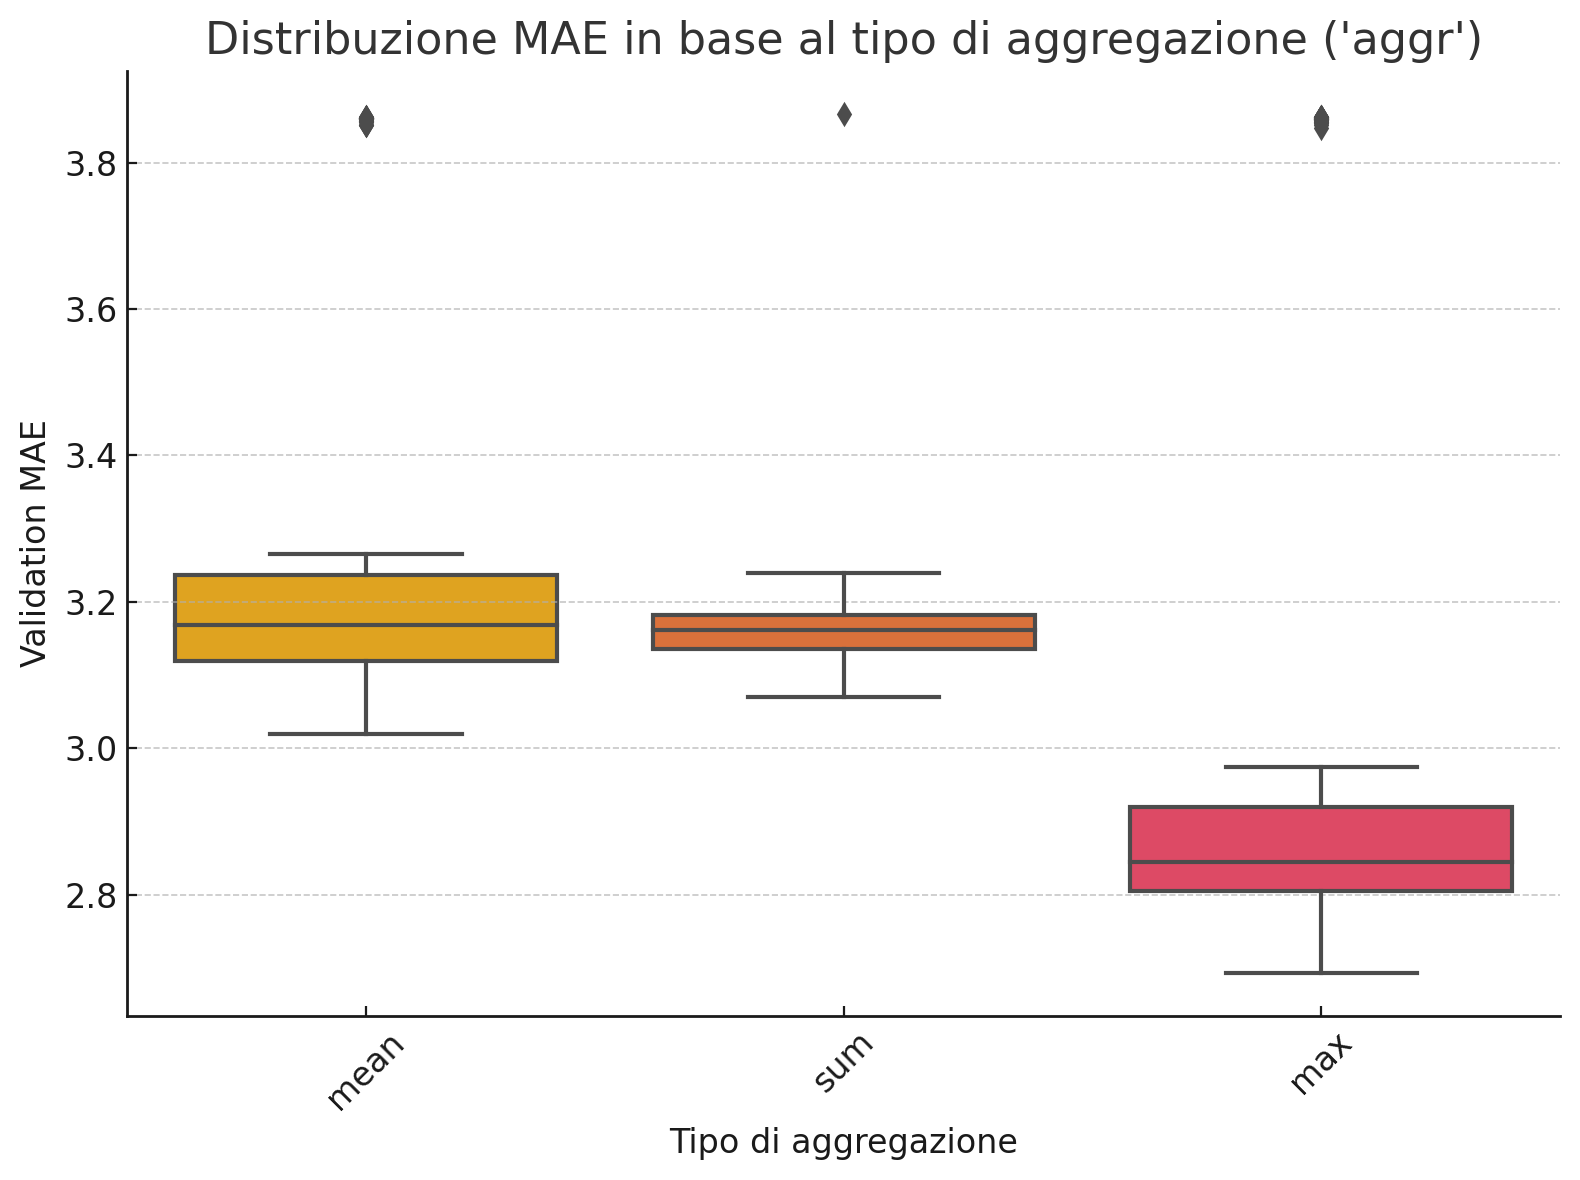

Configurazione migliore:
Params: lr=0.0005, wd=0, ch=256, nl=2, aggr=max, norm=batch_norm, batch_size=512, num_neighbours=256
Early stopping at epoch 33
Final validation MAE: 2.693

# Training loop

In [64]:
model = Model(
    data=data,
    col_stats_dict=col_stats_dict,
    num_layers=2,
    channels=128,
    out_channels=1,
    aggr="max",
    norm="batch_norm",
).to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.0005,
    weight_decay=0
)

scheduler = CosineAnnealingLR(optimizer, T_max=100)

loader_dict = loader_dict_fn(batch_size=512, num_neighbours=256)

early_stopping = EarlyStopping(
    patience=30,
    delta=0.0,
    verbose=True,
    path="best_basic_model.pt"
)

epochs = 200
state_dict = None
test_table = task.get_table("test", mask_input_cols=False)
best_val_metric = -math.inf if higher_is_better else math.inf
best_test_metric = -math.inf if higher_is_better else math.inf
for epoch in range(1, epochs + 1):
    train_loss = train(model, optimizer, loader_dict=loader_dict)

    train_pred = test(model, loader_dict["train"])
    train_metrics = evaluate_performance(train_pred, train_table, task.metrics)
    train_mae_preciso = evaluate_on_full_train(model, loader_dict["train"])

    val_pred = test(model, loader_dict["val"])
    val_metrics = evaluate_performance(val_pred, val_table, task.metrics)

    test_pred = test(model, loader_dict["test"])
    test_metrics = evaluate_performance(test_pred, test_table, task.metrics)
    #print(val_metrics)
    scheduler.step(val_metrics[tune_metric])

    if (higher_is_better and val_metrics[tune_metric] > best_val_metric) or (
            not higher_is_better and val_metrics[tune_metric] < best_val_metric
    ):
        best_val_metric = val_metrics[tune_metric]
        state_dict = copy.deepcopy(model.state_dict())

    #test:
    if (higher_is_better and test_metrics[tune_metric] > best_test_metric) or (
            not higher_is_better and test_metrics[tune_metric] < best_test_metric
    ):
        best_test_metric = test_metrics[tune_metric]
        state_dict_test = copy.deepcopy(model.state_dict())

    current_lr = optimizer.param_groups[0]["lr"]
    print(f"Epoch: {epoch:02d}, Train {tune_metric}: {train_mae_preciso:.2f}, Validation {tune_metric}: {val_metrics[tune_metric]:.2f}, Test {tune_metric}: {test_metrics[tune_metric]:.2f}, LR: {current_lr:.6f}")

    early_stopping(val_metrics[tune_metric], model)

    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch}")
        break
print(f"best validation results: {best_val_metric}")
print(f"best test results: {best_test_metric}")


100%|██████████| 3/3 [00:00<00:00,  7.36it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 01, Train roc_auc: 0.64, Validation roc_auc: 0.48, Test roc_auc: 0.63, LR: 0.000500
Validation metric migliorata. Salvo modello...


100%|██████████| 3/3 [00:00<00:00,  6.88it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 02, Train roc_auc: 0.68, Validation roc_auc: 0.52, Test roc_auc: 0.51, LR: 0.000500
Validation metric migliorata. Salvo modello...


100%|██████████| 3/3 [00:00<00:00,  9.74it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 03, Train roc_auc: 0.74, Validation roc_auc: 0.49, Test roc_auc: 0.65, LR: 0.000500
EarlyStopping counter: 1 / 30


100%|██████████| 3/3 [00:00<00:00,  9.67it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 04, Train roc_auc: 0.73, Validation roc_auc: 0.54, Test roc_auc: 0.71, LR: 0.000500
Validation metric migliorata. Salvo modello...


100%|██████████| 3/3 [00:00<00:00,  9.43it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 05, Train roc_auc: 0.71, Validation roc_auc: 0.54, Test roc_auc: 0.71, LR: 0.000500
EarlyStopping counter: 1 / 30


100%|██████████| 3/3 [00:00<00:00,  9.38it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 06, Train roc_auc: 0.72, Validation roc_auc: 0.53, Test roc_auc: 0.70, LR: 0.000500
EarlyStopping counter: 2 / 30


100%|██████████| 3/3 [00:00<00:00,  9.52it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 07, Train roc_auc: 0.73, Validation roc_auc: 0.53, Test roc_auc: 0.72, LR: 0.000500
EarlyStopping counter: 3 / 30


100%|██████████| 3/3 [00:00<00:00,  9.60it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 08, Train roc_auc: 0.76, Validation roc_auc: 0.49, Test roc_auc: 0.70, LR: 0.000500
EarlyStopping counter: 4 / 30


100%|██████████| 3/3 [00:00<00:00,  9.59it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 09, Train roc_auc: 0.79, Validation roc_auc: 0.47, Test roc_auc: 0.67, LR: 0.000500
EarlyStopping counter: 5 / 30


100%|██████████| 3/3 [00:00<00:00,  7.76it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 10, Train roc_auc: 0.81, Validation roc_auc: 0.49, Test roc_auc: 0.66, LR: 0.000500
EarlyStopping counter: 6 / 30


100%|██████████| 3/3 [00:00<00:00,  7.09it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 11, Train roc_auc: 0.82, Validation roc_auc: 0.48, Test roc_auc: 0.61, LR: 0.000500
EarlyStopping counter: 7 / 30


100%|██████████| 3/3 [00:00<00:00,  9.34it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 12, Train roc_auc: 0.83, Validation roc_auc: 0.48, Test roc_auc: 0.60, LR: 0.000500
EarlyStopping counter: 8 / 30


100%|██████████| 3/3 [00:00<00:00,  9.66it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 13, Train roc_auc: 0.84, Validation roc_auc: 0.52, Test roc_auc: 0.57, LR: 0.000500
EarlyStopping counter: 9 / 30


100%|██████████| 3/3 [00:00<00:00,  9.35it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 14, Train roc_auc: 0.86, Validation roc_auc: 0.53, Test roc_auc: 0.55, LR: 0.000500
EarlyStopping counter: 10 / 30


100%|██████████| 3/3 [00:00<00:00,  9.67it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 15, Train roc_auc: 0.87, Validation roc_auc: 0.49, Test roc_auc: 0.54, LR: 0.000500
EarlyStopping counter: 11 / 30


100%|██████████| 3/3 [00:00<00:00,  9.36it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 16, Train roc_auc: 0.87, Validation roc_auc: 0.50, Test roc_auc: 0.53, LR: 0.000500
EarlyStopping counter: 12 / 30


100%|██████████| 3/3 [00:00<00:00,  9.82it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 17, Train roc_auc: 0.87, Validation roc_auc: 0.50, Test roc_auc: 0.53, LR: 0.000500
EarlyStopping counter: 13 / 30


100%|██████████| 3/3 [00:00<00:00,  9.87it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 18, Train roc_auc: 0.88, Validation roc_auc: 0.53, Test roc_auc: 0.49, LR: 0.000500
EarlyStopping counter: 14 / 30


100%|██████████| 3/3 [00:00<00:00,  9.98it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 19, Train roc_auc: 0.88, Validation roc_auc: 0.54, Test roc_auc: 0.48, LR: 0.000500
EarlyStopping counter: 15 / 30


100%|██████████| 3/3 [00:00<00:00,  7.57it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 20, Train roc_auc: 0.88, Validation roc_auc: 0.56, Test roc_auc: 0.50, LR: 0.000500
Validation metric migliorata. Salvo modello...


100%|██████████| 3/3 [00:00<00:00,  9.83it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 21, Train roc_auc: 0.89, Validation roc_auc: 0.56, Test roc_auc: 0.53, LR: 0.000500
EarlyStopping counter: 1 / 30


100%|██████████| 3/3 [00:00<00:00,  9.48it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 22, Train roc_auc: 0.89, Validation roc_auc: 0.55, Test roc_auc: 0.53, LR: 0.000500
EarlyStopping counter: 2 / 30


100%|██████████| 3/3 [00:00<00:00,  9.63it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 23, Train roc_auc: 0.88, Validation roc_auc: 0.55, Test roc_auc: 0.50, LR: 0.000500
EarlyStopping counter: 3 / 30


100%|██████████| 3/3 [00:00<00:00,  9.51it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 24, Train roc_auc: 0.89, Validation roc_auc: 0.52, Test roc_auc: 0.51, LR: 0.000500
EarlyStopping counter: 4 / 30


100%|██████████| 3/3 [00:00<00:00,  9.35it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 25, Train roc_auc: 0.89, Validation roc_auc: 0.52, Test roc_auc: 0.56, LR: 0.000500
EarlyStopping counter: 5 / 30


100%|██████████| 3/3 [00:00<00:00,  9.64it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 26, Train roc_auc: 0.89, Validation roc_auc: 0.47, Test roc_auc: 0.56, LR: 0.000500
EarlyStopping counter: 6 / 30


100%|██████████| 3/3 [00:00<00:00,  9.56it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 27, Train roc_auc: 0.89, Validation roc_auc: 0.49, Test roc_auc: 0.54, LR: 0.000500
EarlyStopping counter: 7 / 30


100%|██████████| 3/3 [00:00<00:00,  9.33it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 28, Train roc_auc: 0.89, Validation roc_auc: 0.52, Test roc_auc: 0.54, LR: 0.000500
EarlyStopping counter: 8 / 30


100%|██████████| 3/3 [00:00<00:00,  7.90it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 29, Train roc_auc: 0.89, Validation roc_auc: 0.55, Test roc_auc: 0.52, LR: 0.000500
EarlyStopping counter: 9 / 30


100%|██████████| 3/3 [00:00<00:00,  9.07it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 30, Train roc_auc: 0.89, Validation roc_auc: 0.54, Test roc_auc: 0.53, LR: 0.000500
EarlyStopping counter: 10 / 30


100%|██████████| 3/3 [00:00<00:00,  9.29it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 31, Train roc_auc: 0.90, Validation roc_auc: 0.54, Test roc_auc: 0.54, LR: 0.000500
EarlyStopping counter: 11 / 30


100%|██████████| 3/3 [00:00<00:00,  8.53it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 32, Train roc_auc: 0.90, Validation roc_auc: 0.53, Test roc_auc: 0.56, LR: 0.000500
EarlyStopping counter: 12 / 30


100%|██████████| 3/3 [00:00<00:00,  9.12it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 33, Train roc_auc: 0.90, Validation roc_auc: 0.52, Test roc_auc: 0.53, LR: 0.000500
EarlyStopping counter: 13 / 30


100%|██████████| 3/3 [00:00<00:00,  9.45it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 34, Train roc_auc: 0.90, Validation roc_auc: 0.54, Test roc_auc: 0.53, LR: 0.000500
EarlyStopping counter: 14 / 30


100%|██████████| 3/3 [00:00<00:00,  9.14it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 35, Train roc_auc: 0.90, Validation roc_auc: 0.56, Test roc_auc: 0.53, LR: 0.000500
EarlyStopping counter: 15 / 30


100%|██████████| 3/3 [00:00<00:00,  9.18it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 36, Train roc_auc: 0.89, Validation roc_auc: 0.57, Test roc_auc: 0.51, LR: 0.000500
Validation metric migliorata. Salvo modello...


100%|██████████| 3/3 [00:00<00:00,  6.29it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 37, Train roc_auc: 0.90, Validation roc_auc: 0.53, Test roc_auc: 0.50, LR: 0.000500
EarlyStopping counter: 1 / 30


100%|██████████| 3/3 [00:00<00:00,  9.12it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 38, Train roc_auc: 0.90, Validation roc_auc: 0.51, Test roc_auc: 0.48, LR: 0.000500
EarlyStopping counter: 2 / 30


100%|██████████| 3/3 [00:00<00:00,  7.06it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 39, Train roc_auc: 0.90, Validation roc_auc: 0.51, Test roc_auc: 0.51, LR: 0.000500
EarlyStopping counter: 3 / 30


100%|██████████| 3/3 [00:00<00:00,  4.52it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 40, Train roc_auc: 0.90, Validation roc_auc: 0.49, Test roc_auc: 0.53, LR: 0.000500
EarlyStopping counter: 4 / 30


100%|██████████| 3/3 [00:00<00:00,  9.19it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 41, Train roc_auc: 0.90, Validation roc_auc: 0.49, Test roc_auc: 0.53, LR: 0.000500
EarlyStopping counter: 5 / 30


100%|██████████| 3/3 [00:00<00:00,  9.14it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 42, Train roc_auc: 0.90, Validation roc_auc: 0.53, Test roc_auc: 0.50, LR: 0.000500
EarlyStopping counter: 6 / 30


100%|██████████| 3/3 [00:00<00:00,  9.14it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 43, Train roc_auc: 0.90, Validation roc_auc: 0.50, Test roc_auc: 0.49, LR: 0.000500
EarlyStopping counter: 7 / 30


100%|██████████| 3/3 [00:00<00:00,  9.29it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 44, Train roc_auc: 0.90, Validation roc_auc: 0.49, Test roc_auc: 0.50, LR: 0.000500
EarlyStopping counter: 8 / 30


100%|██████████| 3/3 [00:00<00:00,  7.62it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 45, Train roc_auc: 0.90, Validation roc_auc: 0.52, Test roc_auc: 0.53, LR: 0.000500
EarlyStopping counter: 9 / 30


100%|██████████| 3/3 [00:00<00:00,  6.89it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 46, Train roc_auc: 0.90, Validation roc_auc: 0.54, Test roc_auc: 0.54, LR: 0.000500
EarlyStopping counter: 10 / 30


100%|██████████| 3/3 [00:00<00:00,  9.41it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 47, Train roc_auc: 0.90, Validation roc_auc: 0.54, Test roc_auc: 0.56, LR: 0.000500
EarlyStopping counter: 11 / 30


100%|██████████| 3/3 [00:00<00:00,  9.44it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 48, Train roc_auc: 0.90, Validation roc_auc: 0.54, Test roc_auc: 0.55, LR: 0.000500
EarlyStopping counter: 12 / 30


100%|██████████| 3/3 [00:00<00:00,  9.56it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 49, Train roc_auc: 0.90, Validation roc_auc: 0.54, Test roc_auc: 0.56, LR: 0.000500
EarlyStopping counter: 13 / 30


100%|██████████| 3/3 [00:00<00:00,  8.69it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 50, Train roc_auc: 0.90, Validation roc_auc: 0.53, Test roc_auc: 0.55, LR: 0.000500
EarlyStopping counter: 14 / 30


100%|██████████| 3/3 [00:00<00:00,  9.08it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 51, Train roc_auc: 0.90, Validation roc_auc: 0.53, Test roc_auc: 0.55, LR: 0.000500
EarlyStopping counter: 15 / 30


100%|██████████| 3/3 [00:00<00:00,  8.99it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 52, Train roc_auc: 0.90, Validation roc_auc: 0.55, Test roc_auc: 0.54, LR: 0.000500
EarlyStopping counter: 16 / 30


100%|██████████| 3/3 [00:00<00:00,  9.32it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 53, Train roc_auc: 0.90, Validation roc_auc: 0.58, Test roc_auc: 0.53, LR: 0.000500
Validation metric migliorata. Salvo modello...


100%|██████████| 3/3 [00:00<00:00,  7.52it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 54, Train roc_auc: 0.90, Validation roc_auc: 0.56, Test roc_auc: 0.54, LR: 0.000500
EarlyStopping counter: 1 / 30


100%|██████████| 3/3 [00:00<00:00,  7.05it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 55, Train roc_auc: 0.90, Validation roc_auc: 0.54, Test roc_auc: 0.56, LR: 0.000500
EarlyStopping counter: 2 / 30


100%|██████████| 3/3 [00:00<00:00,  9.18it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 56, Train roc_auc: 0.90, Validation roc_auc: 0.54, Test roc_auc: 0.56, LR: 0.000500
EarlyStopping counter: 3 / 30


100%|██████████| 3/3 [00:00<00:00,  9.08it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 57, Train roc_auc: 0.90, Validation roc_auc: 0.54, Test roc_auc: 0.55, LR: 0.000500
EarlyStopping counter: 4 / 30


100%|██████████| 3/3 [00:00<00:00,  9.31it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 58, Train roc_auc: 0.90, Validation roc_auc: 0.55, Test roc_auc: 0.54, LR: 0.000500
EarlyStopping counter: 5 / 30


100%|██████████| 3/3 [00:00<00:00,  8.97it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 59, Train roc_auc: 0.90, Validation roc_auc: 0.55, Test roc_auc: 0.55, LR: 0.000500
EarlyStopping counter: 6 / 30


100%|██████████| 3/3 [00:00<00:00,  8.89it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 60, Train roc_auc: 0.90, Validation roc_auc: 0.56, Test roc_auc: 0.55, LR: 0.000500
EarlyStopping counter: 7 / 30


100%|██████████| 3/3 [00:00<00:00,  9.22it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 61, Train roc_auc: 0.90, Validation roc_auc: 0.55, Test roc_auc: 0.55, LR: 0.000500
EarlyStopping counter: 8 / 30


100%|██████████| 3/3 [00:00<00:00,  9.50it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 62, Train roc_auc: 0.90, Validation roc_auc: 0.55, Test roc_auc: 0.58, LR: 0.000500
EarlyStopping counter: 9 / 30


100%|██████████| 3/3 [00:00<00:00,  7.18it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 63, Train roc_auc: 0.90, Validation roc_auc: 0.55, Test roc_auc: 0.58, LR: 0.000500
EarlyStopping counter: 10 / 30


100%|██████████| 3/3 [00:00<00:00,  7.51it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 64, Train roc_auc: 0.90, Validation roc_auc: 0.56, Test roc_auc: 0.58, LR: 0.000500
EarlyStopping counter: 11 / 30


100%|██████████| 3/3 [00:00<00:00,  9.09it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 65, Train roc_auc: 0.90, Validation roc_auc: 0.56, Test roc_auc: 0.57, LR: 0.000500
EarlyStopping counter: 12 / 30


100%|██████████| 3/3 [00:00<00:00,  9.27it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 66, Train roc_auc: 0.90, Validation roc_auc: 0.56, Test roc_auc: 0.55, LR: 0.000500
EarlyStopping counter: 13 / 30


100%|██████████| 3/3 [00:00<00:00,  9.39it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 67, Train roc_auc: 0.90, Validation roc_auc: 0.57, Test roc_auc: 0.55, LR: 0.000500
EarlyStopping counter: 14 / 30


100%|██████████| 3/3 [00:00<00:00,  9.68it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 68, Train roc_auc: 0.90, Validation roc_auc: 0.56, Test roc_auc: 0.56, LR: 0.000500
EarlyStopping counter: 15 / 30


100%|██████████| 3/3 [00:00<00:00,  9.41it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 69, Train roc_auc: 0.90, Validation roc_auc: 0.53, Test roc_auc: 0.56, LR: 0.000500
EarlyStopping counter: 16 / 30


100%|██████████| 3/3 [00:00<00:00,  9.51it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 70, Train roc_auc: 0.90, Validation roc_auc: 0.51, Test roc_auc: 0.56, LR: 0.000500
EarlyStopping counter: 17 / 30


100%|██████████| 3/3 [00:00<00:00,  9.57it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 71, Train roc_auc: 0.90, Validation roc_auc: 0.54, Test roc_auc: 0.58, LR: 0.000500
EarlyStopping counter: 18 / 30


100%|██████████| 3/3 [00:00<00:00,  7.49it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 72, Train roc_auc: 0.90, Validation roc_auc: 0.56, Test roc_auc: 0.60, LR: 0.000500
EarlyStopping counter: 19 / 30


100%|██████████| 3/3 [00:00<00:00,  6.78it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 73, Train roc_auc: 0.90, Validation roc_auc: 0.56, Test roc_auc: 0.60, LR: 0.000500
EarlyStopping counter: 20 / 30


100%|██████████| 3/3 [00:00<00:00,  9.58it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 74, Train roc_auc: 0.90, Validation roc_auc: 0.57, Test roc_auc: 0.60, LR: 0.000500
EarlyStopping counter: 21 / 30


100%|██████████| 3/3 [00:00<00:00,  9.68it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 75, Train roc_auc: 0.90, Validation roc_auc: 0.57, Test roc_auc: 0.58, LR: 0.000500
EarlyStopping counter: 22 / 30


100%|██████████| 3/3 [00:00<00:00,  9.57it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 76, Train roc_auc: 0.90, Validation roc_auc: 0.55, Test roc_auc: 0.57, LR: 0.000500
EarlyStopping counter: 23 / 30


100%|██████████| 3/3 [00:00<00:00,  9.15it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 77, Train roc_auc: 0.90, Validation roc_auc: 0.58, Test roc_auc: 0.58, LR: 0.000500
Validation metric migliorata. Salvo modello...


100%|██████████| 3/3 [00:00<00:00,  9.58it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 78, Train roc_auc: 0.90, Validation roc_auc: 0.56, Test roc_auc: 0.59, LR: 0.000500
EarlyStopping counter: 1 / 30


100%|██████████| 3/3 [00:00<00:00,  9.62it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 79, Train roc_auc: 0.90, Validation roc_auc: 0.56, Test roc_auc: 0.59, LR: 0.000500
EarlyStopping counter: 2 / 30


100%|██████████| 3/3 [00:00<00:00,  9.25it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 80, Train roc_auc: 0.90, Validation roc_auc: 0.57, Test roc_auc: 0.60, LR: 0.000500
EarlyStopping counter: 3 / 30


100%|██████████| 3/3 [00:00<00:00,  7.68it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 81, Train roc_auc: 0.90, Validation roc_auc: 0.57, Test roc_auc: 0.61, LR: 0.000500
EarlyStopping counter: 4 / 30


100%|██████████| 3/3 [00:00<00:00,  7.10it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 82, Train roc_auc: 0.90, Validation roc_auc: 0.56, Test roc_auc: 0.60, LR: 0.000500
EarlyStopping counter: 5 / 30


100%|██████████| 3/3 [00:00<00:00,  9.41it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 83, Train roc_auc: 0.90, Validation roc_auc: 0.55, Test roc_auc: 0.59, LR: 0.000500
EarlyStopping counter: 6 / 30


100%|██████████| 3/3 [00:00<00:00,  9.79it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 84, Train roc_auc: 0.90, Validation roc_auc: 0.56, Test roc_auc: 0.59, LR: 0.000500
EarlyStopping counter: 7 / 30


100%|██████████| 3/3 [00:00<00:00,  9.54it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 85, Train roc_auc: 0.90, Validation roc_auc: 0.56, Test roc_auc: 0.55, LR: 0.000500
EarlyStopping counter: 8 / 30


100%|██████████| 3/3 [00:00<00:00,  9.69it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 86, Train roc_auc: 0.90, Validation roc_auc: 0.55, Test roc_auc: 0.53, LR: 0.000500
EarlyStopping counter: 9 / 30


100%|██████████| 3/3 [00:00<00:00,  9.20it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 87, Train roc_auc: 0.90, Validation roc_auc: 0.55, Test roc_auc: 0.54, LR: 0.000500
EarlyStopping counter: 10 / 30


100%|██████████| 3/3 [00:00<00:00,  9.03it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 88, Train roc_auc: 0.90, Validation roc_auc: 0.55, Test roc_auc: 0.55, LR: 0.000500
EarlyStopping counter: 11 / 30


100%|██████████| 3/3 [00:00<00:00,  9.38it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 89, Train roc_auc: 0.90, Validation roc_auc: 0.55, Test roc_auc: 0.56, LR: 0.000500
EarlyStopping counter: 12 / 30


100%|██████████| 3/3 [00:00<00:00,  9.23it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 90, Train roc_auc: 0.90, Validation roc_auc: 0.55, Test roc_auc: 0.58, LR: 0.000500
EarlyStopping counter: 13 / 30


100%|██████████| 3/3 [00:00<00:00,  7.22it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 91, Train roc_auc: 0.90, Validation roc_auc: 0.53, Test roc_auc: 0.57, LR: 0.000500
EarlyStopping counter: 14 / 30


100%|██████████| 3/3 [00:00<00:00,  9.47it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 92, Train roc_auc: 0.90, Validation roc_auc: 0.52, Test roc_auc: 0.55, LR: 0.000500
EarlyStopping counter: 15 / 30


100%|██████████| 3/3 [00:00<00:00,  9.56it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 93, Train roc_auc: 0.90, Validation roc_auc: 0.52, Test roc_auc: 0.55, LR: 0.000500
EarlyStopping counter: 16 / 30


100%|██████████| 3/3 [00:00<00:00,  9.17it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 94, Train roc_auc: 0.90, Validation roc_auc: 0.52, Test roc_auc: 0.55, LR: 0.000500
EarlyStopping counter: 17 / 30


100%|██████████| 3/3 [00:00<00:00,  9.39it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 95, Train roc_auc: 0.90, Validation roc_auc: 0.53, Test roc_auc: 0.52, LR: 0.000500
EarlyStopping counter: 18 / 30


100%|██████████| 3/3 [00:00<00:00,  9.51it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 96, Train roc_auc: 0.90, Validation roc_auc: 0.54, Test roc_auc: 0.52, LR: 0.000500
EarlyStopping counter: 19 / 30


100%|██████████| 3/3 [00:00<00:00,  9.31it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 97, Train roc_auc: 0.90, Validation roc_auc: 0.54, Test roc_auc: 0.55, LR: 0.000500
EarlyStopping counter: 20 / 30


100%|██████████| 3/3 [00:00<00:00,  9.02it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 98, Train roc_auc: 0.90, Validation roc_auc: 0.54, Test roc_auc: 0.59, LR: 0.000500
EarlyStopping counter: 21 / 30


100%|██████████| 3/3 [00:00<00:00,  9.17it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 99, Train roc_auc: 0.91, Validation roc_auc: 0.55, Test roc_auc: 0.57, LR: 0.000500
EarlyStopping counter: 22 / 30


100%|██████████| 3/3 [00:00<00:00,  7.84it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 100, Train roc_auc: 0.90, Validation roc_auc: 0.54, Test roc_auc: 0.53, LR: 0.000500
EarlyStopping counter: 23 / 30


100%|██████████| 3/3 [00:00<00:00,  8.61it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 101, Train roc_auc: 0.90, Validation roc_auc: 0.55, Test roc_auc: 0.49, LR: 0.000500
EarlyStopping counter: 24 / 30


100%|██████████| 3/3 [00:00<00:00,  9.46it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 102, Train roc_auc: 0.91, Validation roc_auc: 0.55, Test roc_auc: 0.54, LR: 0.000500
EarlyStopping counter: 25 / 30


100%|██████████| 3/3 [00:00<00:00,  9.04it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 103, Train roc_auc: 0.90, Validation roc_auc: 0.56, Test roc_auc: 0.57, LR: 0.000500
EarlyStopping counter: 26 / 30


100%|██████████| 3/3 [00:00<00:00,  9.38it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 104, Train roc_auc: 0.90, Validation roc_auc: 0.55, Test roc_auc: 0.56, LR: 0.000500
EarlyStopping counter: 27 / 30


100%|██████████| 3/3 [00:00<00:00,  9.12it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 105, Train roc_auc: 0.91, Validation roc_auc: 0.55, Test roc_auc: 0.56, LR: 0.000500
EarlyStopping counter: 28 / 30


100%|██████████| 3/3 [00:00<00:00,  9.49it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 106, Train roc_auc: 0.91, Validation roc_auc: 0.55, Test roc_auc: 0.54, LR: 0.000500
EarlyStopping counter: 29 / 30


100%|██████████| 3/3 [00:00<00:00,  9.31it/s]


Epoch: 107, Train roc_auc: 0.91, Validation roc_auc: 0.55, Test roc_auc: 0.52, LR: 0.000500
EarlyStopping counter: 30 / 30
Early stopping triggered at epoch 107
best validation results: 0.577180125781656
best test results: 0.7205267558528429


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


# La gnn aiuta, e molto!

# Loading the best model

In [65]:
#model.load_state_dict(torch.load("best_model.pt"))